In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import math
import sys
import time
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import operator
import math

import cupy as cp
from scipy import linalg
from matplotlib.backends.backend_pdf import PdfPages

# TRAIN U, V, W

In [2]:
def altern_iter(I, S, U_old, V_old, W_old, reg):
    start_time = time.time()
    
    p_dim = I.shape[0]
    image_no = I.shape[1]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = S.shape[1]
    k_dim = V_old.shape[0]
    
    ##### RESHAPE U ######
    
    U_new = np.empty((f_dim*unit_no*k_dim ,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                U_new[n*f_dim*k_dim + k*f_dim + i] = U_old[f_dim*n + i , k]
                
    U_old = U_new
    
    #### T = VS (n,k,t x 1) VEC PREPARATION ####
    T_vec = np.empty((unit_no*k_dim*image_no,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for t in range(image_no):
                T_knt = cp.dot(V_old[k,:] , S[t,n,:])
                T_vec[n*k_dim*image_no + k*image_no + t] = T_knt
    
    ######## W CALCULATION #######
    #######################
    X = np.empty((image_no, unit_no*f_dim), dtype=np.float32)
    
    for t in tnrange(image_no):
        for n in range(unit_no):
            for i in range(f_dim):
                T_ids = np.arange(0, k_dim*image_no, image_no) + n*image_no*k_dim + t
                U_ids = np.arange(0, k_dim*f_dim, f_dim) + n*k_dim*f_dim + i
                
                X[t, n*f_dim + i] = cp.dot(T_vec[T_ids].reshape((1,-1)) , U_old[U_ids].reshape((-1,1)))
    
    W_old = np.linalg.lstsq(X, I.T)[0].T
    
    ##### W STANDARDIZE #####
    W_sum =np.sum(np.abs(W_old))/W_old.size
    W_exp = math.log10(W_sum)
    W_old = W_old/W_sum*10**(W_exp*reg)
    ##################
    
    ##### U CALCULATION ####
    ######################
    
    ######### MAKE XX #######
    XTX = np.zeros((f_dim * unit_no * k_dim , f_dim * unit_no * k_dim), dtype=np.float32)
    
    for n1 in tnrange(unit_no):
        for n2 in range(unit_no):
            for k1 in range(k_dim):
                for k2 in range(k_dim):
                    for i1 in range(f_dim):
                        for i2 in range(f_dim):
                            index1 = n1*k_dim*f_dim + k1*f_dim + i1
                            index2 = n2*k_dim*f_dim + k2*f_dim + i2
                            if index1 >= index2:
                                TT = cp.dot(T_vec[image_no*(n1*k_dim+k1):image_no*(n1*k_dim+k1+1)],
                                            T_vec[image_no*(n2*k_dim+k2):image_no*(n2*k_dim+k2+1)])
                                XTX_entry = cp.dot(W_old[:, n1*f_dim+i1] , W_old[:, n2*f_dim+i2]) * TT
                                XTX[n1*k_dim*f_dim + k1*f_dim + i1, n2*k_dim*f_dim + k2*f_dim + i2] = XTX_entry
                                XTX[n2*k_dim*f_dim + k2*f_dim + i2, n1*k_dim*f_dim + k1*f_dim + i1] = XTX_entry
    
    
    ######## MAKE XY ########
    XTY = np.zeros((f_dim * unit_no * k_dim ,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                TI_nkx = cp.dot(T_vec[image_no*(n*k_dim+k):image_no*(n*k_dim+k+1)] , I.T)
                XTY[n*k_dim*f_dim + k*f_dim + i] = cp.dot(TI_nkx , W_old[:, n*f_dim+i])
    
    
    XTX_inv = linalg.inv(XTX + 0.0000001*np.identity(XTX.shape[0]))
    
    U_old = cp.dot(XTX_inv, XTY)
    
    #### U STANDARDIZE ######
    U_sum = np.sum(np.abs(U_old))/U_old.size
    U_exp = math.log10(U_sum)    
    U_old = U_old/U_sum*10**(U_exp*reg)
    #######
    
    ##### RESHAPE U ######
    
    U_new = np.empty((f_dim*unit_no , k_dim), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                U_new[f_dim*n + i , k] = U_old[n*f_dim*k_dim + k*f_dim + i]
                
    U_old = U_new
    
    ##### Estimate V #####
    
    ##### MAKE XTX AND XTY #####
    XTX = np.zeros((t_dim * k_dim, t_dim * k_dim), dtype=np.float32)
    XTY = np.zeros((t_dim * k_dim, 1), dtype=np.float32)
    
    WU = np.empty((unit_no, k_dim, p_dim), dtype=np.float32)
    for n in range(unit_no):
        WU[n,:,:] = cp.dot(U_old[2*n:2*n+2 ,:].T , W_old[:, 2*n:2*n+2].T)
    
    for m1 in tnrange(t_dim):
        for m2 in range(t_dim):
            for k1 in range(k_dim):
                for k2 in range(k_dim):
                    index1 = k1*t_dim + m1
                    index2 = k2*t_dim + m2
                    if index1 >= index2:
                        WUS1 = cp.dot(WU[:,k1,:].T, S[:,:,m1].T).reshape((-1,))
                        WUS2 = cp.dot(WU[:,k2,:].T, S[:,:,m2].T).reshape((-1,))
                        XTX_entry = cp.dot(WUS1, WUS2)
                        XTX[k1*t_dim + m1 , k2*t_dim + m2] = XTX_entry
                        XTX[k2*t_dim + m2 , k1*t_dim + m1] = XTX_entry
                
    for m in tnrange(t_dim):
        for k in range(k_dim):
            XTY_entry = 0
                
            for n in range(unit_no):
                SI_nmx = cp.dot(S[:,n,m].reshape((1,-1)) , I.T)
                XTY_entry += cp.dot(SI_nmx, WU[n,k,:])
                
            XTY[k*t_dim + m] = XTY_entry
    
    XTX_inv = linalg.inv(XTX + 0.0000001*np.identity(XTX.shape[0]))
    
    V_new = cp.dot(XTX_inv, XTY)
    
    V_old = np.empty((k_dim, t_dim), dtype = np.float32)
    for k in range(k_dim):
        for m in range(t_dim):
            V_old[k,m] = V_new[k*t_dim + m]

    ##### STANDARDIZE V#######

    V_sum = np.sum(np.abs(V_old))/V_old.size
    V_exp = math.log10(V_sum)
    V_old = V_old / V_sum*10**(V_exp*reg)
    
    end_time = time.time()
    print(end_time - start_time)
    return U_old, V_old, W_old


In [3]:
def altern_train(I_file, S_file, U_file, V_file, W_file, sorted_file, unit_no, pixel_no, image_no, iter_no , reg, save_dir):
    
    I = np.load(I_file).T.astype(np.float32)
    S = np.load(S_file).astype(np.float32)
    U = np.load(U_file).astype(np.float32)
    V = np.load(V_file).astype(np.float32)
    W = np.load(W_file).T[:,:-1].astype(np.float32)
    sorted_units = np.load(sorted_file)
    
    ###### PARTIAL TRAIN #######
    unit_ids = sorted_units[:unit_no]
    unit_ids_2 = np.empty((unit_no*2,))
    
    for i in range(unit_no):
        unit_ids_2[2*i] = sorted_units[i]*2
        unit_ids_2[2*i+1] = sorted_units[i]*2+1
    unit_ids_2 = unit_ids_2.astype(np.int)
    
    U = U[unit_ids_2, :]
    W = W[:pixel_no, unit_ids_2]
    
    I = I[:pixel_no, :image_no]
    S = S[:image_no,unit_ids,:]
    I_mean = np.mean(I, axis=1)
    S_mean = np.mean(S, axis=0)
    I = I-I_mean.reshape((-1,1))
    S = S-S_mean

    ###########
    
    V = np.hstack((V, np.zeros((V.shape[0],1), dtype = np.float32)))
    
    U_train = np.empty((iter_no+1, U.shape[0], U.shape[1]), dtype=np.float32)
    V_train = np.empty((iter_no+1, V.shape[0], V.shape[1]), dtype=np.float32)
    W_train = np.empty((iter_no+1, W.shape[0], W.shape[1]), dtype=np.float32)
    
    U_train[0] = U
    V_train[0] = V
    W_train[0] = W

    for i in tnrange(iter_no):
        
        U, V, W = altern_iter(I, S, U_train[i], V_train[i], W_train[i], reg)
        U_train[i+1] = U
        V_train[i+1] = V
        W_train[i+1] = W
        
    np.save(os.path.join(save_dir, "part_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(100*reg)+"_U_weights.npy"), U_train)
    np.save(os.path.join(save_dir, "part_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(100*reg)+"_V_weights.npy"), V_train)
    np.save(os.path.join(save_dir, "part_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(100*reg)+"_W_weights.npy"), W_train)
    
    #np.save(os.path.join(save_dir, "altern_" + str(iter_no) + "_U_weights.npy"), U_train)
    #np.save(os.path.join(save_dir, "altern_" + str(iter_no) + "_V_weights.npy"), V_train)
    #np.save(os.path.join(save_dir, "altern_" + str(iter_no) + "_W_weights.npy"), W_train)

In [4]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy"
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k7_U_init.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_k7_V_init.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy"
iter_no = 1
unit_no = 500
pixel_no = 95*146
image_no = 9800
reg = 0.5
sorted_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/weights/"



altern_train(I_file, S_file, U_file, V_file, W_file, sorted_file, unit_no, pixel_no, image_no, iter_no, reg, save_dir)

/home/joon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



118092.76631689072



# CONSTANT TRAIN

In [4]:
def altern_const_train(I_file, S_file, U_file, V_file, W_file, sorted_file, save_dir):
    I = np.load(I_file).T
    S = np.load(S_file)
    U = np.load(U_file)
    V = np.load(V_file)
    W = np.load(W_file)
    sorted_units = np.load(sorted_file)
    
    unit_ids = sorted_units[:500]
    
    #I = I[:730, :]
    S = S[:,unit_ids,:]
    
    #p_dim = I.shape[0]
    #image_no = I.shape[1]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = W.shape[0]//2
    k_dim = V.shape[1]
    iter_no = U.shape[0]
    
    #C_array = np.empty((730, 3*iter_no-2))
    C = np.mean(I[:,:], axis=1).reshape((-1,1))
    C = np.tile(C, (1,3*iter_no-2))
    print(C.shape)
    S = np.mean(S, axis = 0)
    print(S.shape)
    
    ###### C CALCULATION ######
    
    for i in tnrange(3*iter_no-2):

        for n in range(unit_no):

            if i%3 == 0:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3, :, 2*n : 2*n+2] , U[i//3, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
            
            elif i%3 == 1:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3+1, :, 2*n : 2*n+2] , U[i//3, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
            
            elif i%3 == 2:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3+1, :, 2*n : 2*n+2] , U[i//3+1, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
    
    
    np.save(os.path.join(save_dir, "part_altern_"+U_file[-25:-14] +"_C_weights.npy"), C)
    

In [5]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy"
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_U_weights.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_V_weights.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_W_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/weights/"
sorted_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"




altern_const_train(I_file, S_file, U_file, V_file, W_file, sorted_file, save_dir)

(13870, 4)
(500, 50)


# Decode

In [15]:
def altern_decode(S_file, U_file, V_file, W_file, C_file, sorted_file, save_dir):

    S = np.load(S_file)
    U = np.load(U_file)
    V = np.load(V_file)
    W = np.load(W_file)
    C = np.load(C_file).T
    sorted_units = np.load(sorted_file)
    
    unit_ids = sorted_units[:]
    
    #S = S[:,unit_ids,:]
    
    S=S[-250:,unit_ids,:]
    
    p_dim = W.shape[1]
    image_no = S.shape[0]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = unit_ids.shape[0]
    k_dim = V.shape[1]
    iter_no = U.shape[0]
    
    

    altern_decoded = np.zeros((3*iter_no-2, image_no, p_dim))
    
    for i in tnrange(3*iter_no-2):

        for n in tnrange(unit_no):
            if i%3 == 0:
                S_part = S[:,n,:].T
                WUn =  cp.dot(W[i//3,:,2*n:2*n+2] , U[i//3,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            elif i%3 == 1:
                S_part = S[:,n,:].T
                WUn = cp.dot(W[i//3+1,:,2*n:2*n+2] , U[i//3,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            elif i%3 == 2:
                S_part = S[:,n,:].T
                WUn = cp.dot(W[i//3+1,:,2*n:2*n+2] , U[i//3+1,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            
            
    print(altern_decoded.shape)
            
    for i in tnrange(3*iter_no-2):
            #altern_decoded[i,:] += np.tile(C[i,:].reshape((1,p_dim)), (image_no, 1))
            altern_decoded[i,:] += C[i,:].reshape((1,p_dim))
            
            
    np.save(os.path.join(save_dir, "yass_part_altern_"+U_file[-25:-14]+"_train_decoded.npy"), altern_decoded)
    
    
    


In [16]:
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_U_weights.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_V_weights.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_W_weights.npy"
C_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_i1_u500_r50_C_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/decoded/"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"



altern_decode(S_file, U_file, V_file, W_file, C_file, sorted_units_file, save_dir)



(4, 250, 13870)


# Testing CORRELATION

In [22]:
def altern_corr(I_file, altern_file, simple_file, save_dir):
    test = np.load(I_file)[:,:]
    altern = np.load(altern_file)
    simple = np.load(simple_file)[:,:]
    
    iter_no = altern.shape[0]
    image_no = altern.shape[1]
    
    corr_array = np.empty((image_no, iter_no+1))
    print(corr_array.shape)
    
    for i in tnrange(image_no):
        test_img = test[i,:]
        simple_img = simple[i,:]
        simple_corr = np.corrcoef(test_img.reshape(-1), simple_img.reshape(-1))[0][1]
        corr_array[i,0] = simple_corr
        
        for j in range(iter_no):
            altern_img = altern[j,i,:]
            altern_corr = np.corrcoef(test_img.reshape(-1), altern_img.reshape(-1))[0][1]
            corr_array[i,j+1] = altern_corr
    
    mean_corr_array = np.nanmean(corr_array, axis=0)
    print(mean_corr_array)
    
    #np.save(os.path.join(save_dir, "altern_"+str(iter_no-1) +"_test_corr.npy"), mean_corr_array)
    np.save(os.path.join(save_dir, "part_altern_"+str(altern_file[-28:-17]) +"_test_corr.npy"), mean_corr_array)
    

In [23]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_part_altern_i1_u500_r50_test_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/test_corr/"



altern_corr(I_file, altern_file, simple_file, save_dir)

(100, 5)



[ 0.96366828 -0.03686635  0.94291248  0.94109496  0.96472359]


[ 0.96366828 -0.03686635  0.94291248  0.94109496  0.96472359]


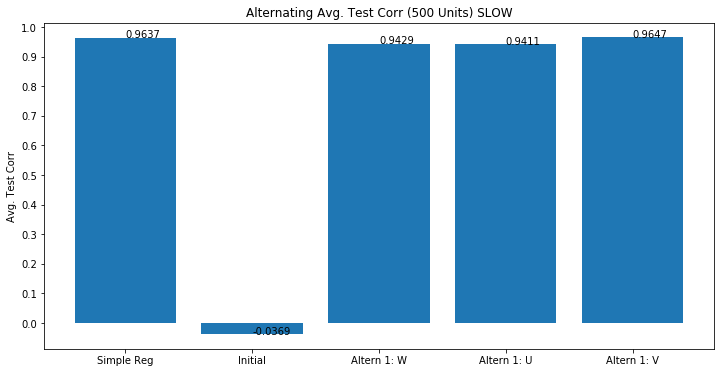

In [32]:
corr_bars = np.load("/ssd/joon/2017_11_29_ns/yass/test_corr/part_altern_i1_u500_r50_test_corr.npy")
x_labels = ["Simple Reg", "Initial", "Altern 1: W", "Altern 1: U", "Altern 1: V"]
           #"Altern 2: W", "Altern 2: U", "Altern 2: V"]
            #"Altern 3: W", "Altern 3: U", "Altern 3: V"]
           #"Altern 4: W", "Altern 4: U", "Altern 4: V"]
            #"Altern 5: W", "Altern 5: U", "Altern 5: V",
           #"Altern 6 W", "Altern 6: U", "Altern 6: V"]
plt.figure(figsize = (12,6))

plt.bar(x_labels, corr_bars)
plt.yticks(np.arange(0,1.001, 0.1))
plt.ylabel("Avg. Test Corr")
plt.title("Alternating Avg. Test Corr (500 Units) SLOW")
for i in range(len(x_labels)):
    plt.annotate(str(round(corr_bars[i], 4)) , xy = (x_labels[i], corr_bars[i]))

print(corr_bars)

# MSE CALCULATION & PLOT

In [27]:
def altern_mse(I_file, altern_file, simple_file, save_dir):
    #test = np.load(I_file)[:,:]
    test = np.load(I_file)[-250:,:]
    altern = np.load(altern_file)
    #simple = np.load(simple_file)[:,:]
    #simple = np.load(simple_file)[-250:,:]
    
    iter_no = altern.shape[0]
    image_no = altern.shape[1]
    
    mse_array = np.empty((image_no, iter_no+1))
    
    
    for j in range(iter_no):
    
        for i in range(image_no):
            test_img = test[i,:]
            #simple_img = simple[i,:]
            #simple_mse = np.sum(np.square(test_img - simple_img))
            mse_array[i,0] = 0
            
            
            altern_img = altern[j,i,:]
            img_mse = np.sum(np.square(test_img - altern_img))
            mse_array[i,j+1] = img_mse
    
    mean_mse_array = np.mean(mse_array/image_no/test.shape[1], axis=0)
    print(mean_mse_array)
    
    np.save(os.path.join(save_dir, "part_altern_"+str(altern_file[-28:-17]) +"_train_mse.npy"), mean_mse_array)

In [28]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_part_altern_i1_u500_r50_train_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/test_corr/"


altern_mse(I_file, altern_file, simple_file, save_dir)

[0.00000000e+00 1.08073430e+03 7.40802541e-01 2.66485431e+00
 2.63233335e+01]


[14.58536949 21.89157915 15.0195451  16.09077035 18.55498781]


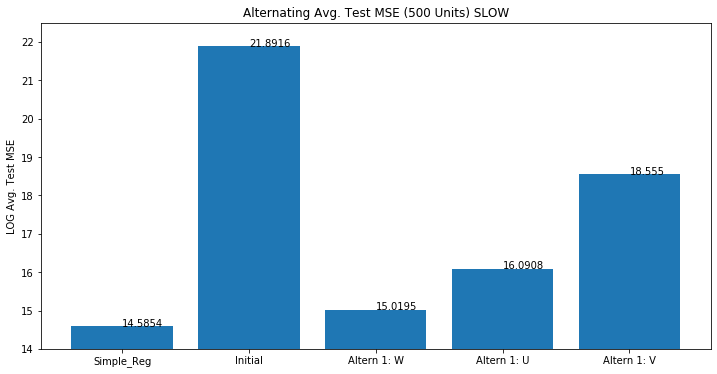

In [10]:
mse_bars = np.load("/ssd/joon/2017_11_29_ns/yass/test_corr/part_altern_i1_u500_r50_train_mse.npy")
x_labels = ["Simple_Reg", "Initial", "Altern 1: W", "Altern 1: U", "Altern 1: V"]
           #"Altern 2: W", "Altern 2: U", "Altern 2: V"]
            #"Altern 3: W", "Altern 3: U", "Altern 3: V"]
           #"Altern 4: W", "Altern 4: U", "Altern 4: V",
            #"Altern 5: W", "Altern 5: U", "Altern 5: V",
           #"Altern 6 W", "Altern 6: U", "Altern 6: V"]
plt.figure(figsize = (12,6))

plt.bar(x_labels, mse_bars)
plt.ylabel("LOG Avg. Test MSE")
plt.ylim(14,22.5)
plt.title("Alternating Avg. Test MSE (500 Units) SLOW")
for i in range(len(x_labels)):
    plt.annotate(str(round(mse_bars[i], 4)) , xy = (x_labels[i], mse_bars[i]))

print(mse_bars)

# PLOT IMAGES

In [63]:
def plot_decoded(I_file, simple_file, altern_file, index, save_dir):
    
    test = np.load(I_file)[:3000, :2190]
    simple = np.load(simple_file)[:3000, :2190]
    altern = np.load(altern_file)
    
    iter_no = altern.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no+2, figsize = (14, 5))
    
    img0 = axs[0].imshow(test[index, :].reshape((15, 146)).T, cmap = "Greys_r")
    img1 = axs[1].imshow(simple[index, :].T.reshape((15, 146)).T, cmap = "Greys_r")
    
    for i in range(iter_no):
        axs[i+2].imshow(altern[i, index, :].T.reshape((15, 146)).T, cmap = "Greys_r")
    
    #plt.colorbar(img0, ax=axs[0], shrink = 0.4)
    #plt.colorbar(img1, ax=axs[1], shrink = 0.4)
    #plt.colorbar(img2, ax=axs[2], shrink = 0.4)
    #plt.colorbar(img3, ax=axs[3], shrink = 0.4)
    
    axs[0].set_title("True")
    axs[1].set_title("YASS")
    axs[2].set_title("Altern Init")
    
    for i in range(iter_no//3):
        axs[3*(i+1)].set_title("Train " +str(i)+" U")
        axs[3*(i+1)+1].set_title("Train " +str(i)+" W")
        axs[3*(i+1)+2].set_title("Train " +str(i)+" V")
    
    for i in range(iter_no+2):
        axs[i].axis("off")
    
    fig.suptitle("Image "+str(index)+": YASS vs. Alternating Comparison", fontsize = 16)
    
def multi_plot_decoded(I_file, simple_file, altern_file, plot_no, save_dir):
    
    with PdfPages(os.path.join(save_dir, "part_altern_3_yass_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            index = np.random.randint(0, 100)
            fig = plot_decoded(I_file, simple_file, altern_file, index, save_dir)
            pdf.savefig(fig)
    
    

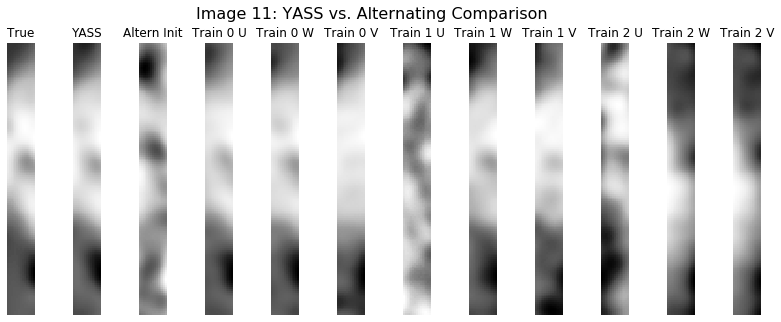

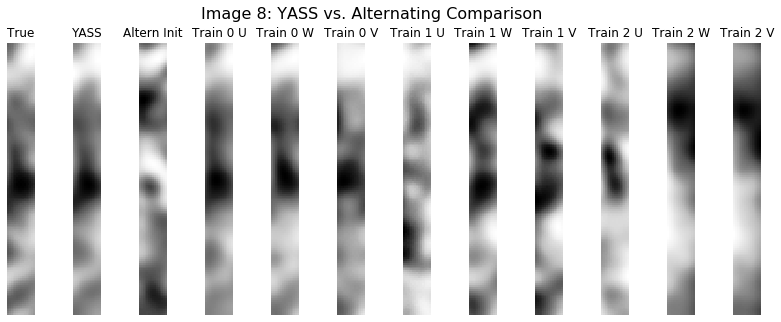

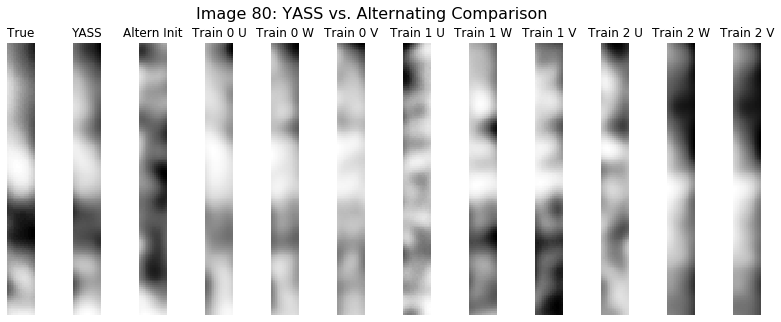

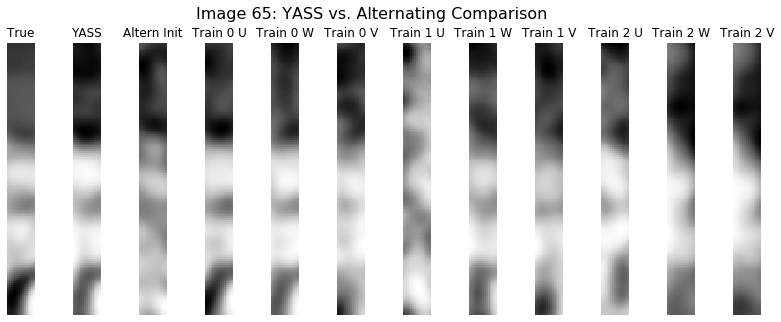

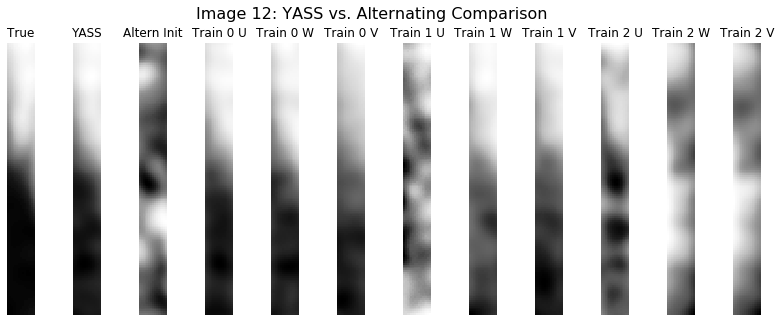

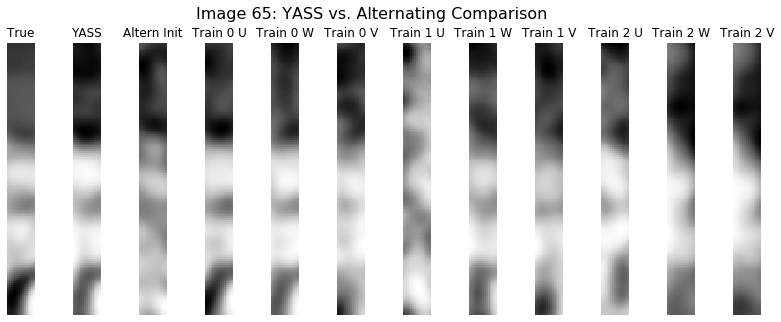

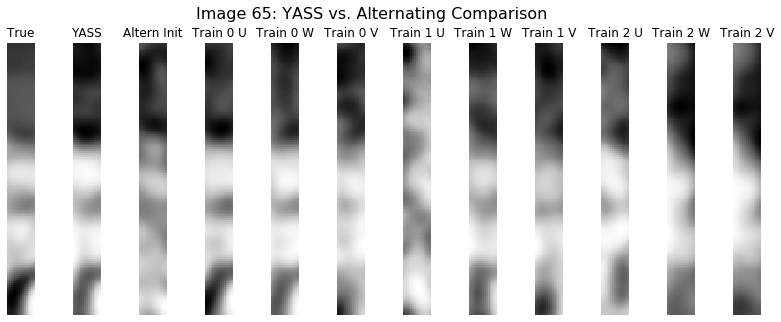

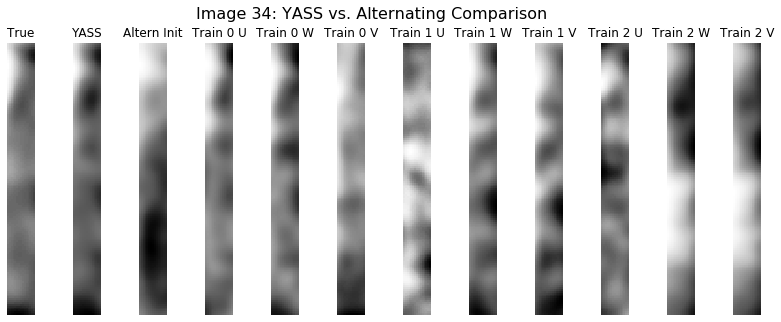

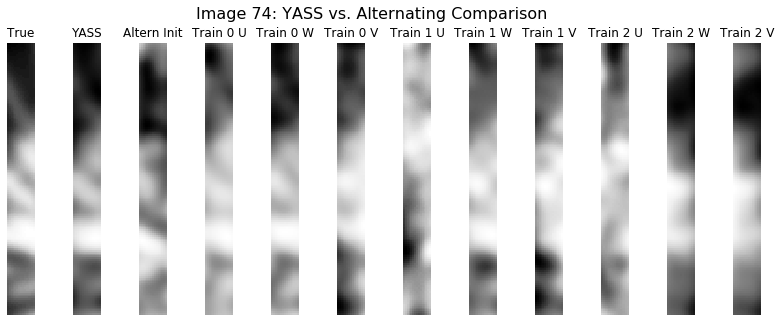

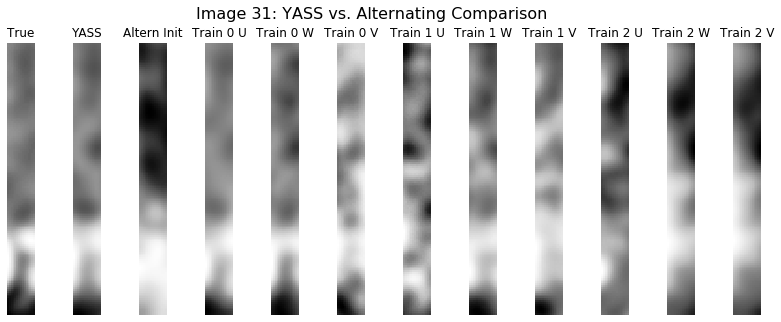

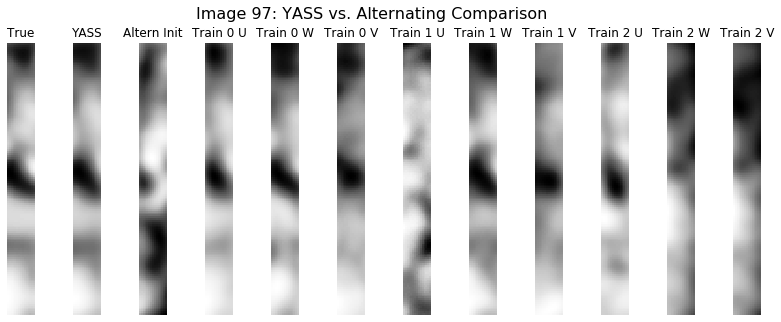

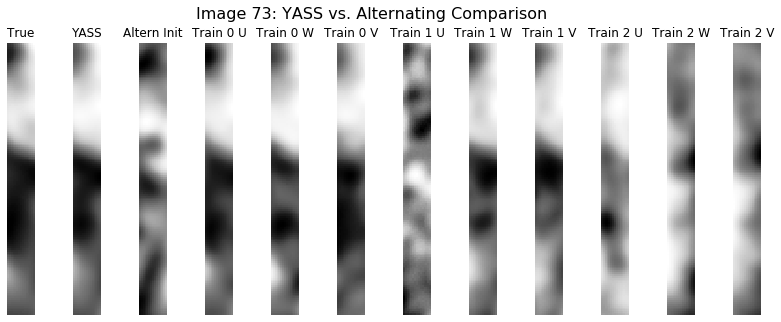

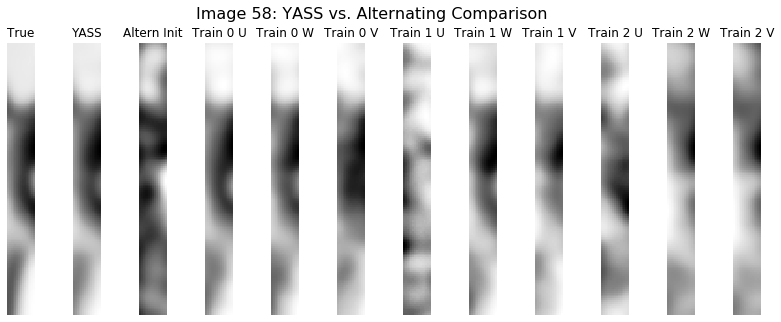

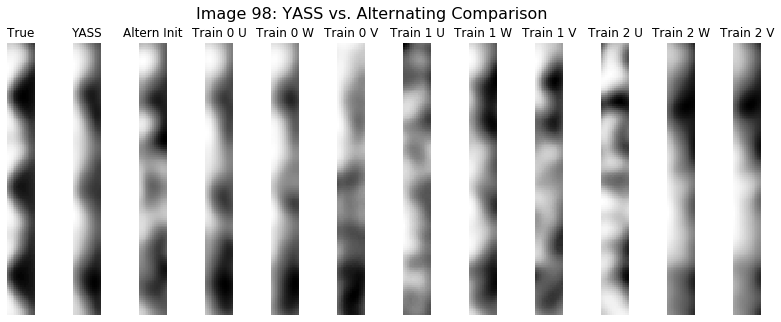

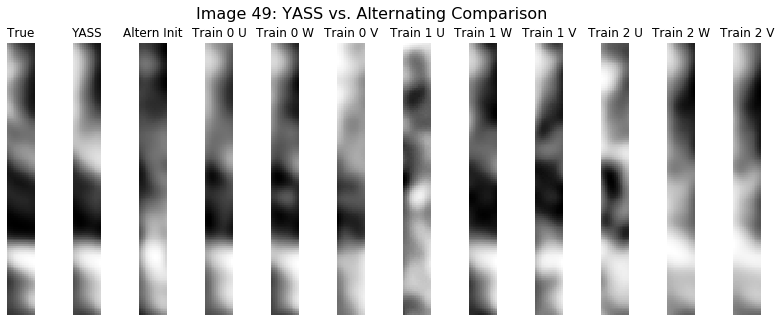

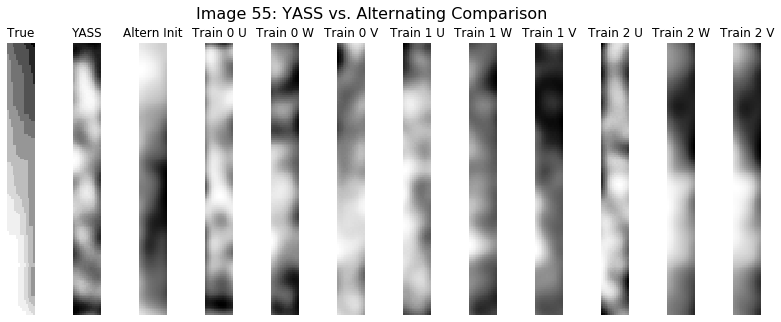

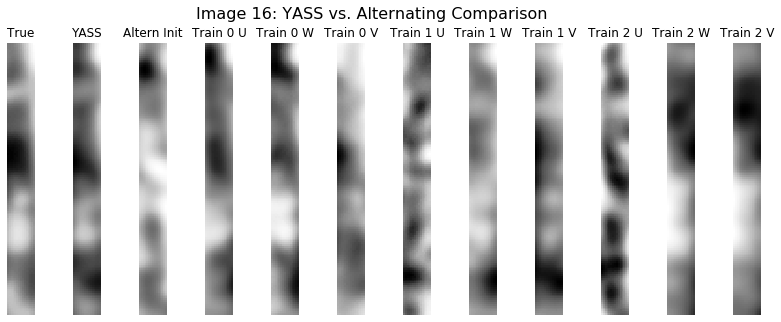

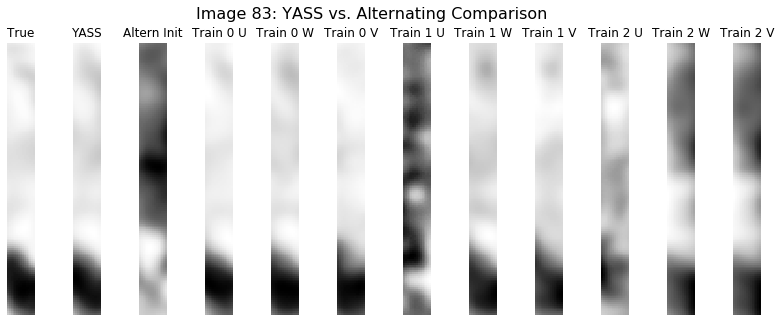

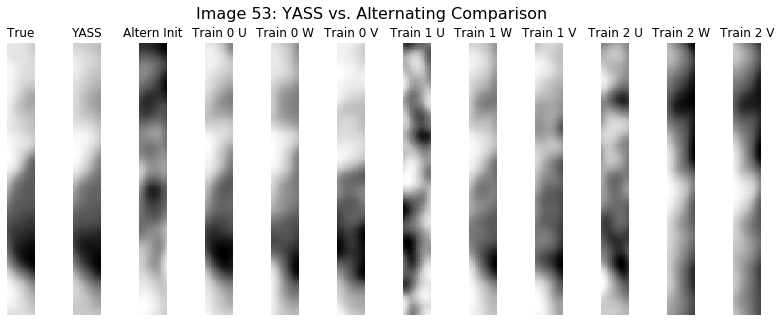

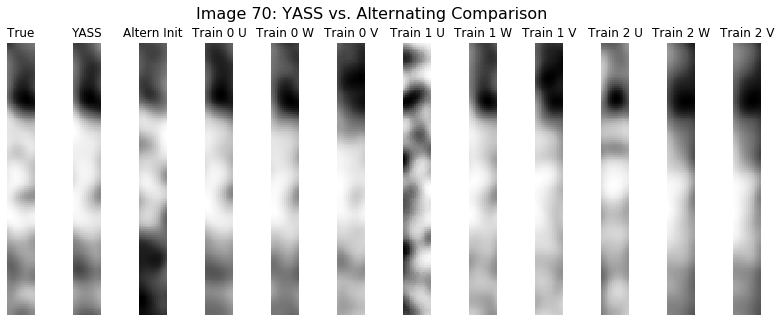

In [64]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_part_altern_3_test_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
plot_no = 20

multi_plot_decoded(I_file, simple_file, altern_file, plot_no, save_dir)

# Plot Weights

In [37]:
def plot_u_weights(U_file, sorted_units_file, unit_no, save_dir):
    U = np.load(U_file)
    sorted_units = np.load(sorted_units_file)
    

    iter_no = U.shape[0]
    print(iter_no)
    
    """
    plt_ids = np.empty((unit_no*2,))
    
    for i in tnrange(unit_no):
        unit = sorted_units[i]
        plt_ids[i*2] = 2*unit
        plt_ids[i*2+1] = 2*unit+1
        
    plt_ids = plt_ids.astype(np.int)
    """
    fig, axs = plt.subplots(ncols = iter_no, figsize = (12,10))
    
    for i in tnrange(iter_no):
        #img = axs[i].imshow(U[i,plt_ids,:])
        img = axs[i].imshow(U[i,:unit_no*2,:])
        plt.colorbar(img, ax=axs[i])
        axs[i].set_title("Train Step "+str(i), fontsize = 15)
        
    fig.suptitle("Alternating U Weights (Top 30 Units)", fontsize = 16)
        
    
    
    
    

3


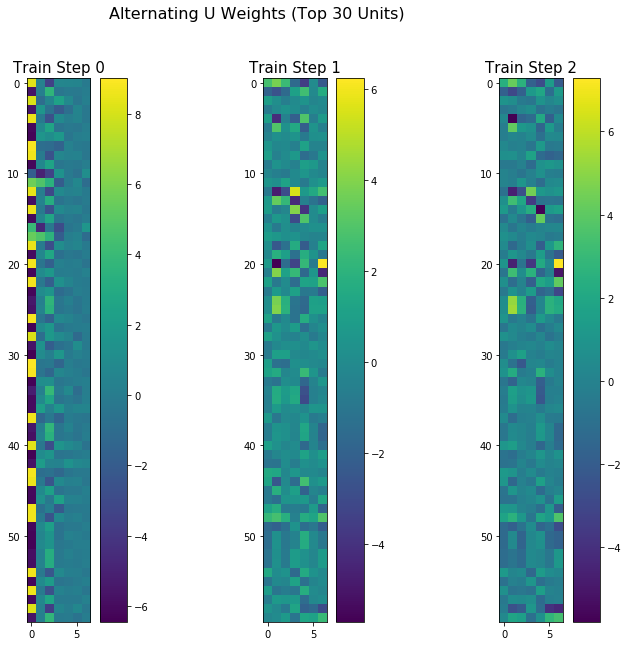

In [38]:
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_2_U_weights.npy"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
unit_no = 30
save_dir = "/ssd/joon/2017_11_29_ns/figures/"


plot_u_weights(U_file, sorted_units_file, unit_no, save_dir)

In [39]:
def plot_v_weights(V_file, save_dir):
    V = np.load(V_file)
    iter_no = V.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no, figsize = (10,6))
    
    for i in tnrange(iter_no):
        img = axs[i].imshow(V[i].T)
        plt.colorbar(img, ax=axs[i])
        axs[i].set_title("Train Step "+str(i), fontsize = 15)
        
    fig.suptitle("Alternating V Weights", fontsize = 16)
    
    
    

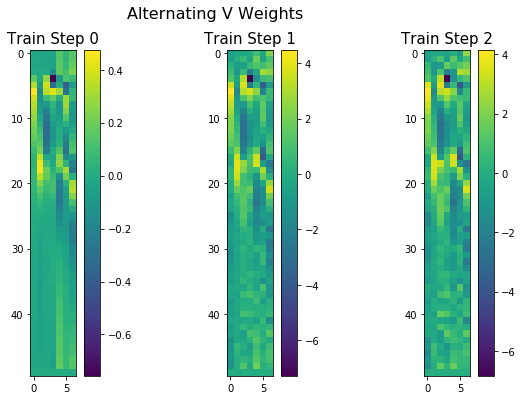

In [40]:
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_2_V_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"


plot_v_weights(V_file, save_dir)

In [44]:
def plot_w_weights(W_file, unit, save_dir):
    
    W = np.load(W_file)
    iter_no = W.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no, nrows=2, figsize = (12,12))
    
    for i in range(iter_no):
        img0 = axs[0,i].imshow(W[i,:,2*unit].reshape((10,146)).T)
        img1 = axs[1,i].imshow(W[i,:,2*unit+1].reshape((10,146)).T)
        axs[0,i].set_title("Train "+str(i)+" ON")
        axs[1,i].set_title("Train "+str(i)+" OFF")
        axs[0,i].axis("off")
        axs[1,i].axis("off")
        plt.colorbar(img0, ax=axs[0,i], shrink =0.8)
        plt.colorbar(img1, ax=axs[1,i], shrink =0.8)
        
    fig.suptitle("Unit "+str(unit)+ " Alternating W Weights", fontsize = 16, y=0.98)
    #fig.tight_layout()
    
def multi_plot_w_weights(W_file, sorted_units_file, unit_no, save_dir):
    sorted_units = np.load(sorted_units_file)
    
    with PdfPages(os.path.join(save_dir, "yass_part_altern_2_W_weights.pdf")) as pdf:
        for i in tnrange(unit_no):
            #unit = sorted_units[i]
            unit = i
            fig = plot_w_weights(W_file, unit, save_dir)
            pdf.savefig(fig)
            
            
    
    

/home/joon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


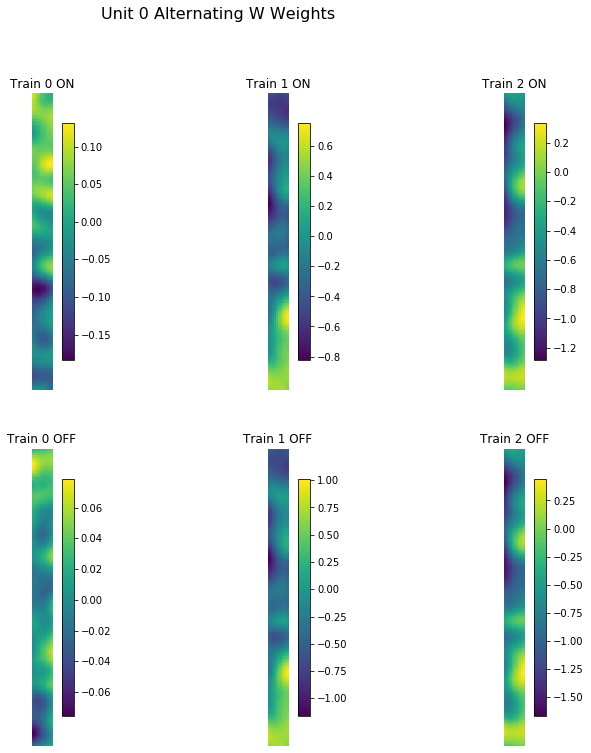

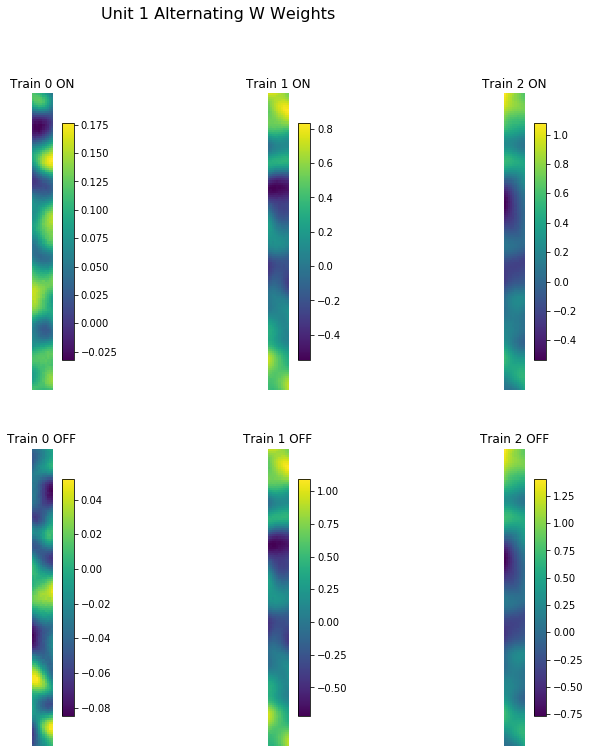

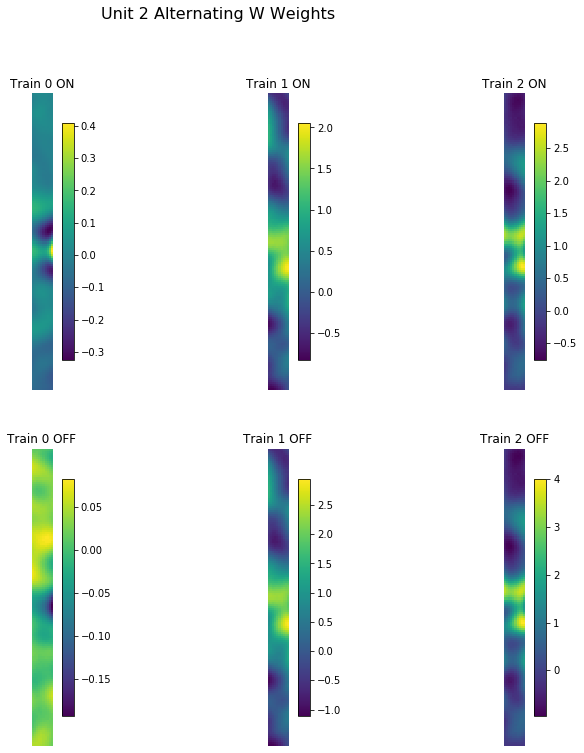

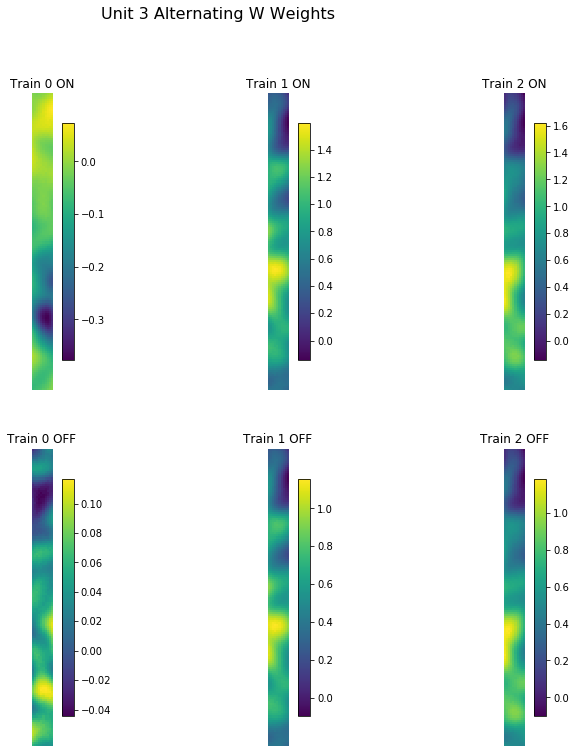

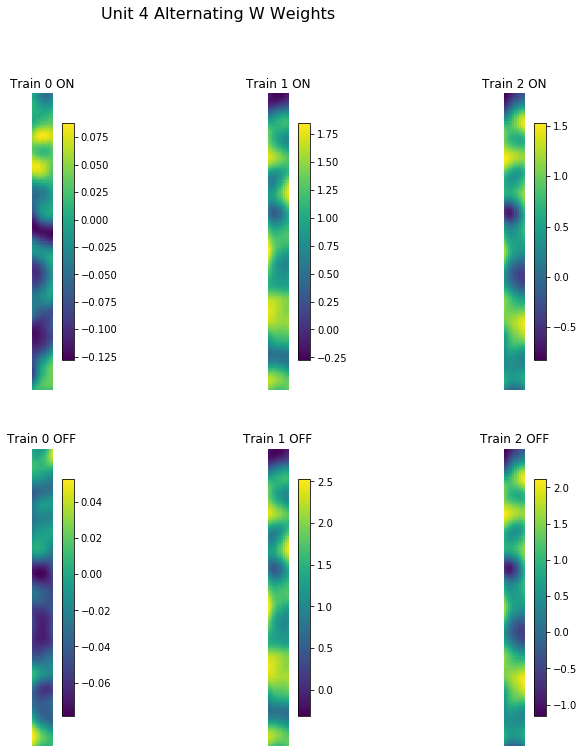

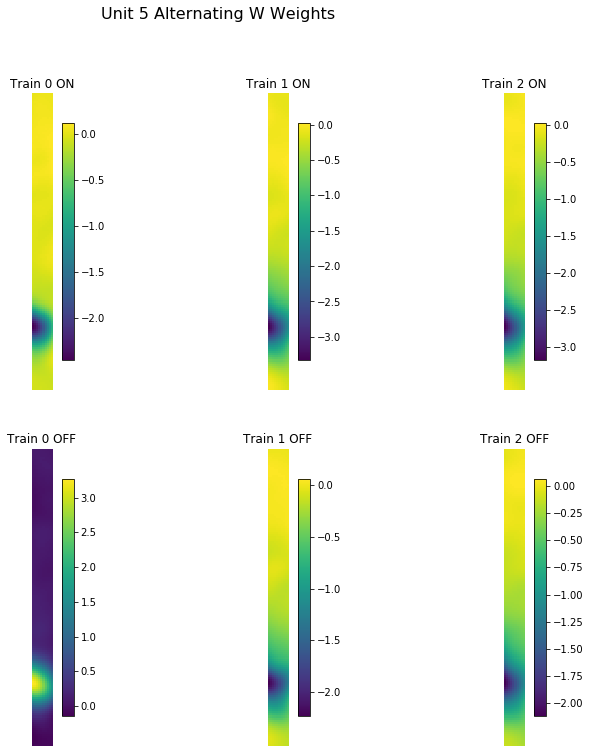

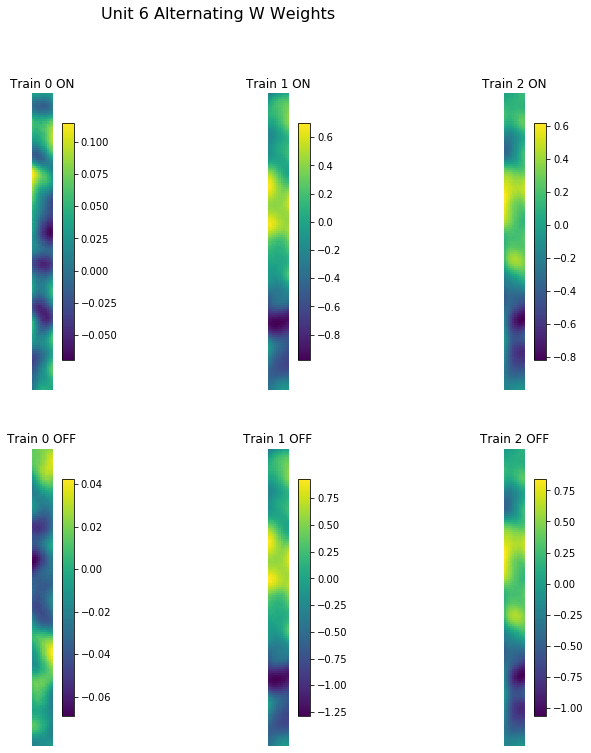

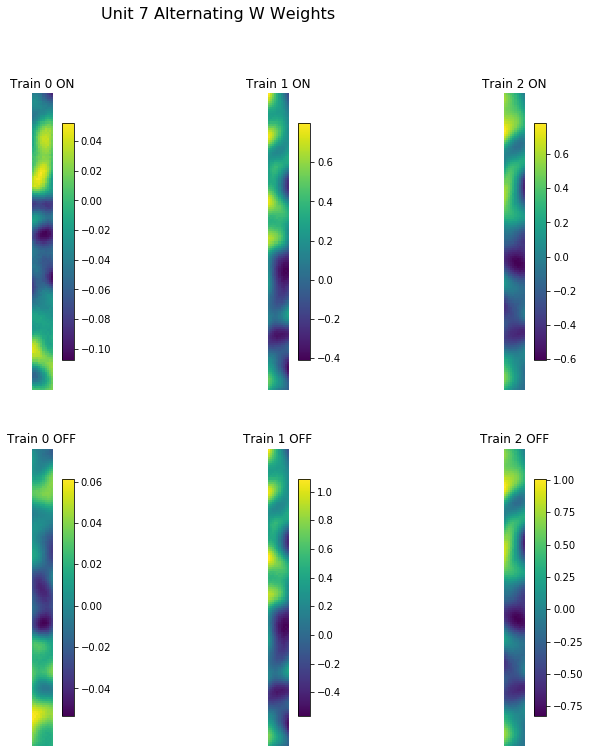

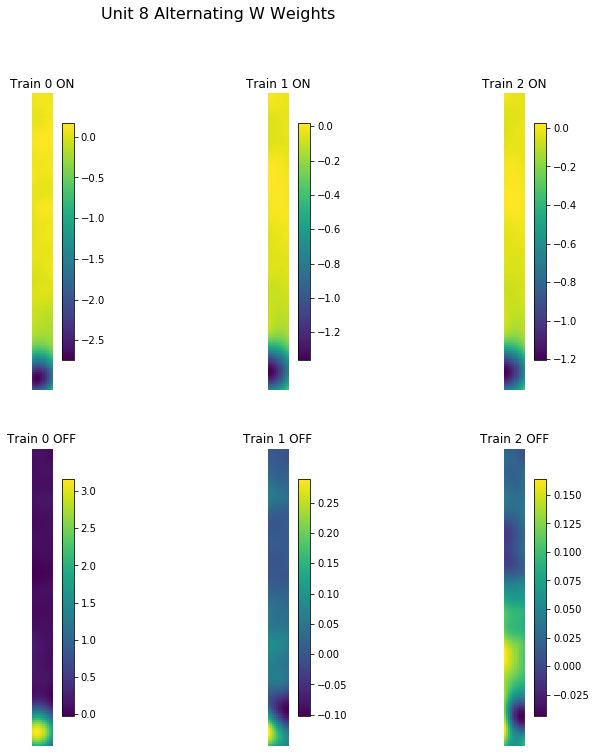

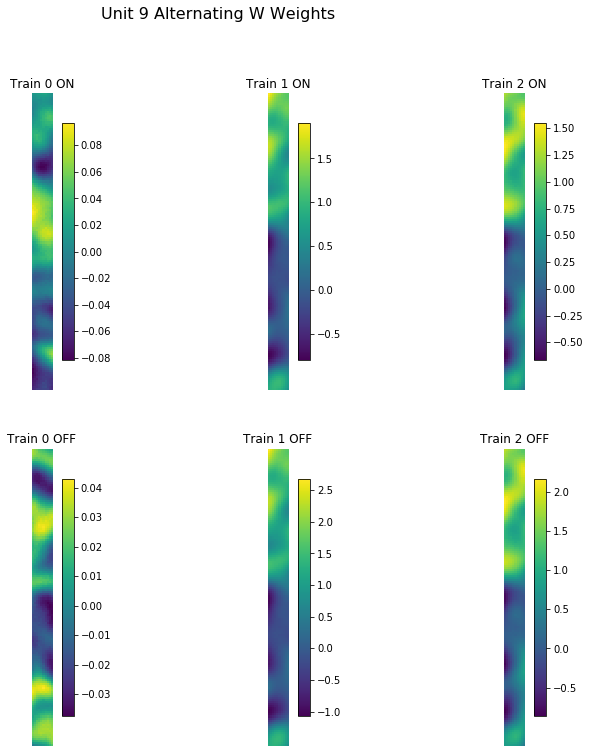

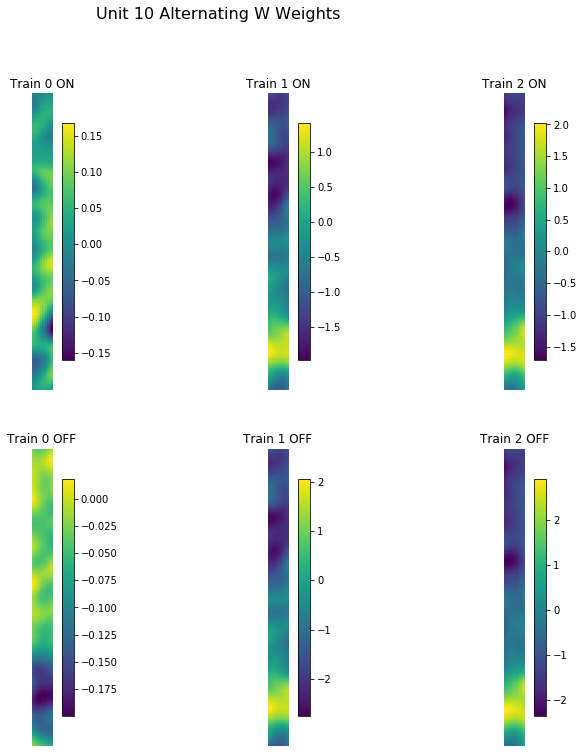

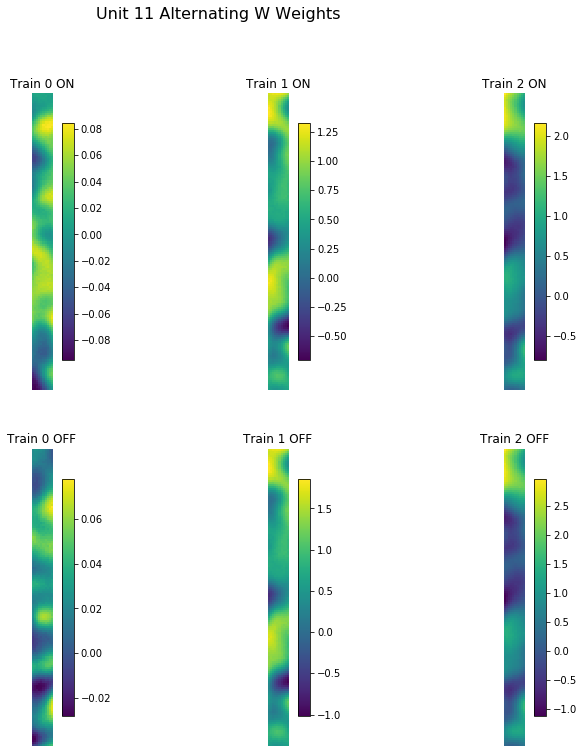

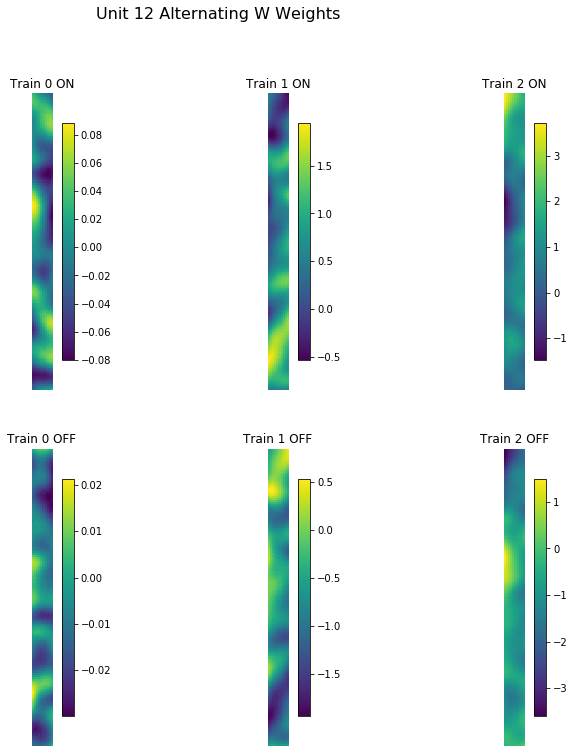

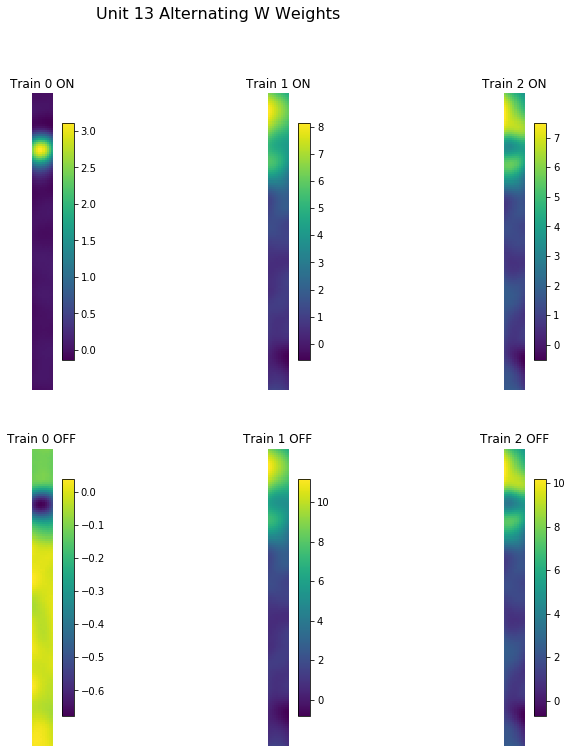

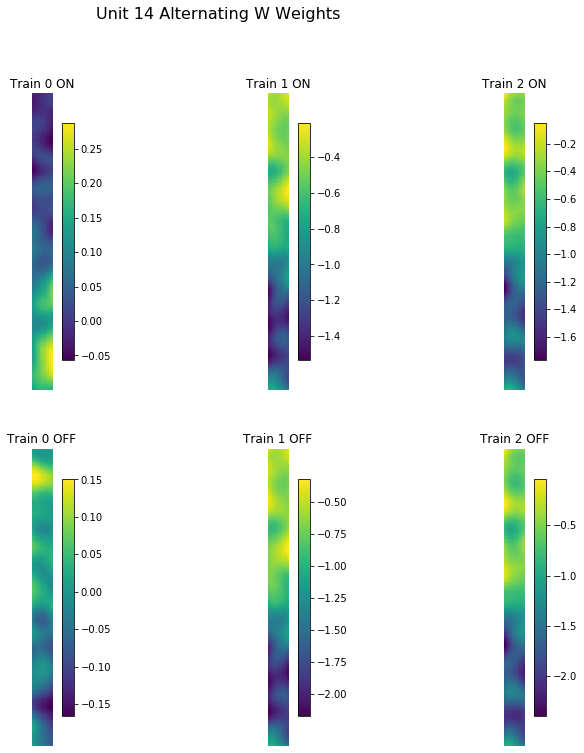

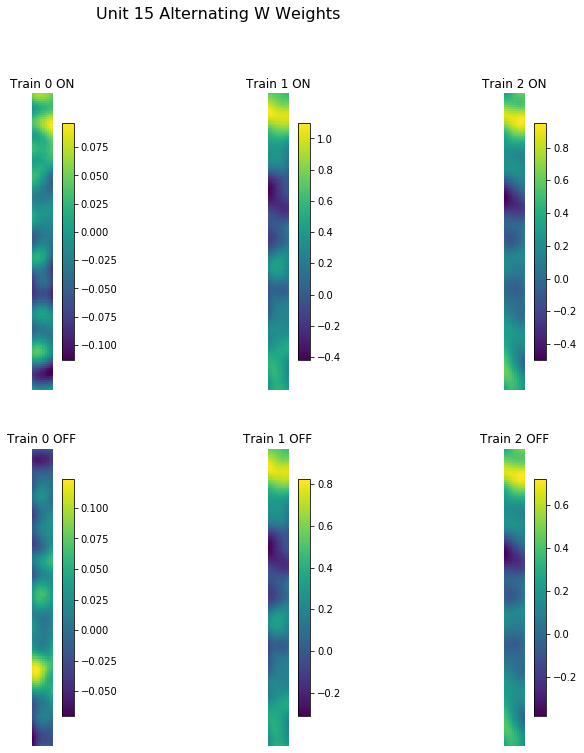

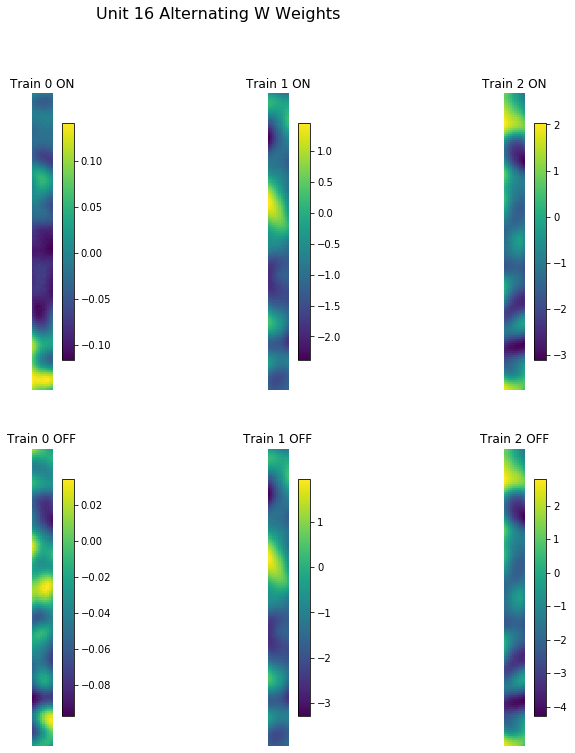

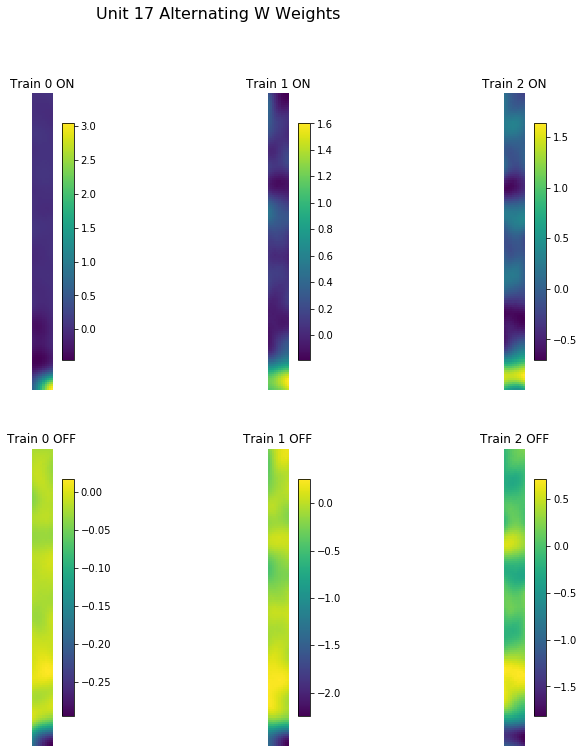

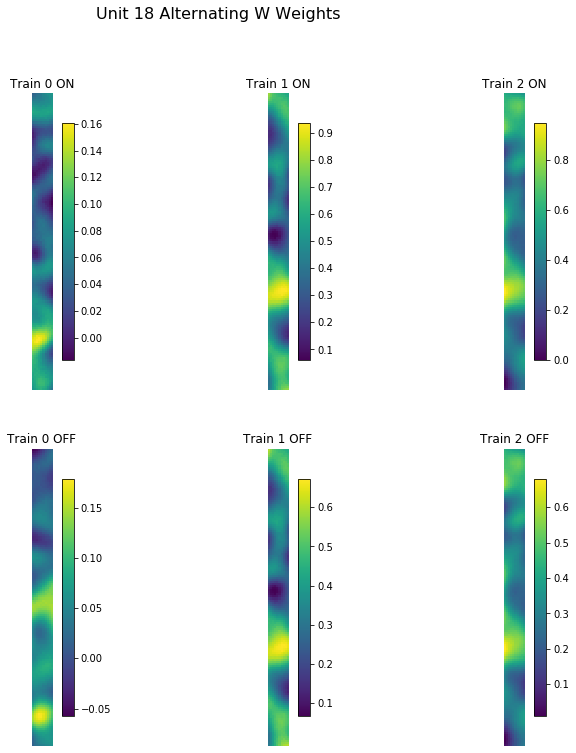

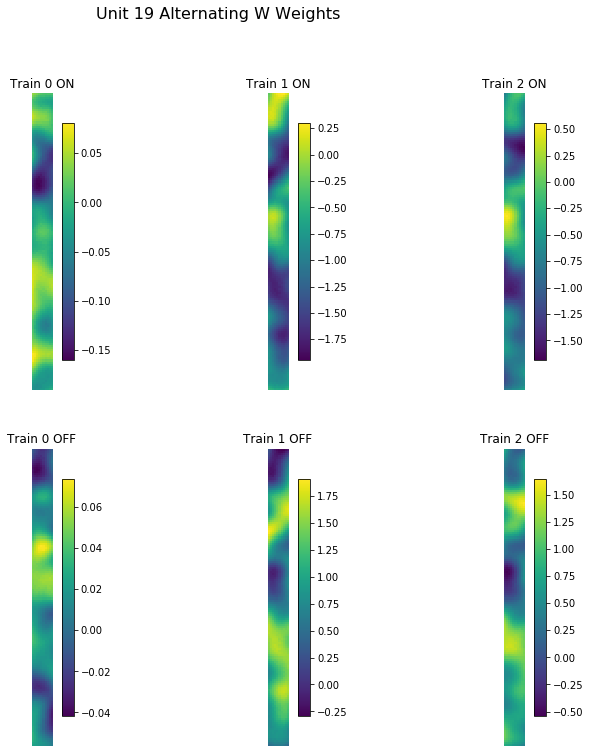

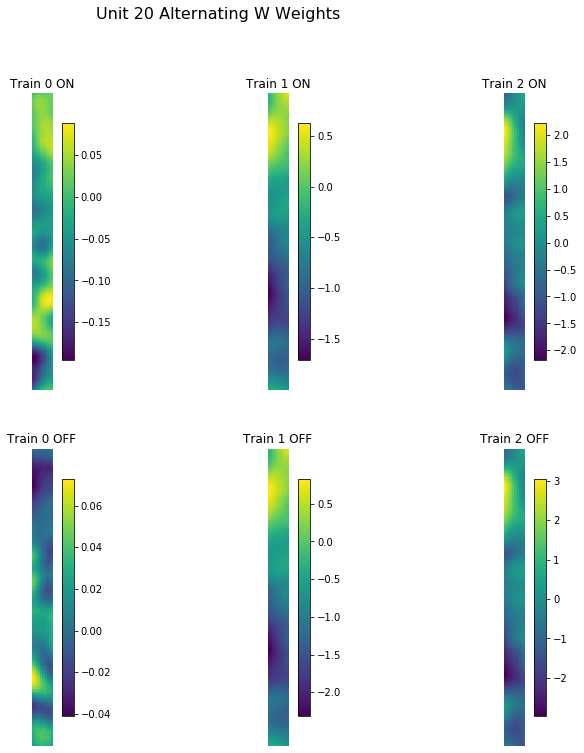

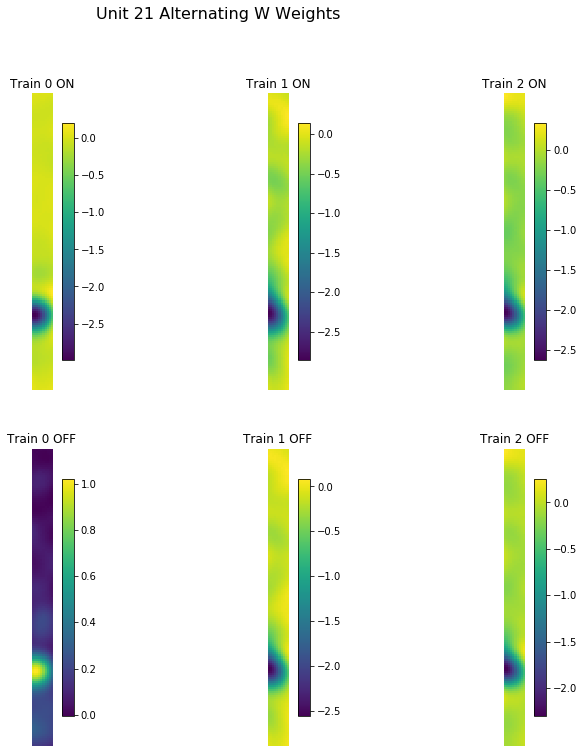

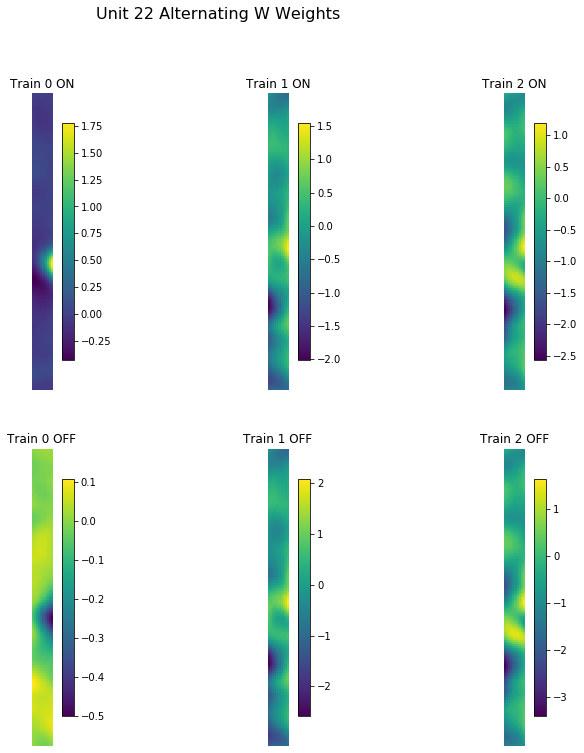

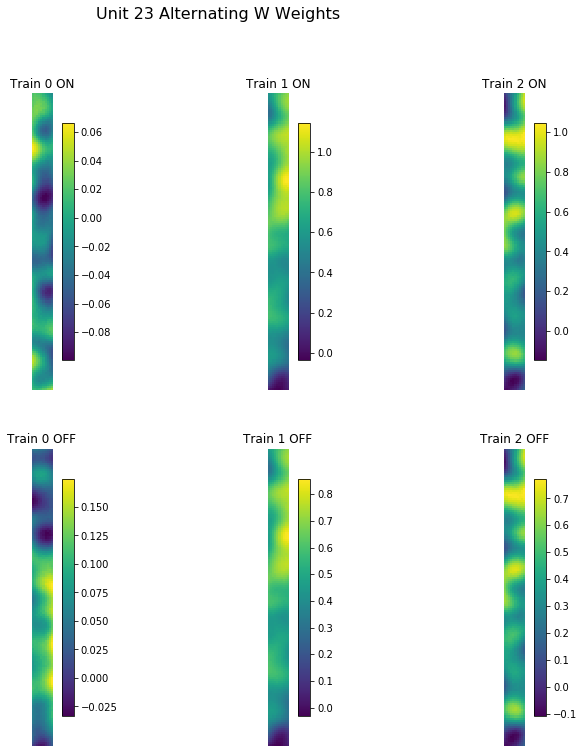

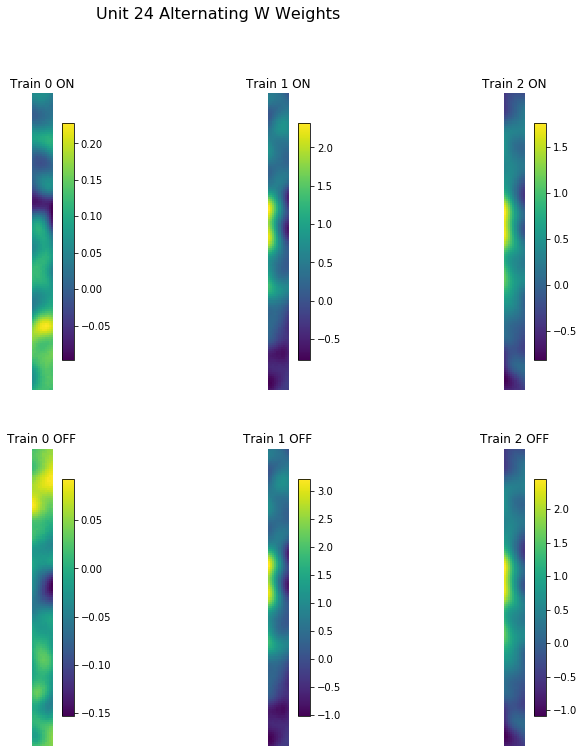

In [45]:
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/part_altern_2_W_weights.npy"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
unit_no = 25
save_dir = "/ssd/joon/2017_11_29_ns/figures/"



multi_plot_w_weights(W_file, sorted_units_file, unit_no, save_dir)

In [10]:
ones = np.ones((3,4))
twos = np.ones((4,2))

print(np.matmul(ones, twos))

[[4. 4.]
 [4. 4.]
 [4. 4.]]


In [11]:
ones = np.asarray([[[1, 2, 3],
                 [4,5,6]],
                 [[7,8,9],
                 [10,11,12]]])

print(ones)
print(ones.reshape((2,-1)))
print(ones.reshape((2,-1)).T)

print(np.matmul(ones))

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]]
[[ 1  7]
 [ 2  8]
 [ 3  9]
 [ 4 10]
 [ 5 11]
 [ 6 12]]
